# Twitter Sentiment Analysis

A construção da rede foi baseada em uma aula que tive da Udacity, do "PyThorch Scholarship Challenge", no qual aprendi sobre redes neurais profundas (CNNs, LSTMs, etc.) Não encontrei um link específico para o código desenvolvido por eles, mas vou deixar o notebook, que utilizei como base, junto dos arquivos. 

O meu objetivo aqui vai fazer uma análise exploratória dos dados e treinar um algoritmo capaz de classificar os sentimentos desses tweets em labels de 1 a 3, sendo:

|1. Negativo |2. Neutro |3. Positivo |
|:---|:---|:---|
| Sarcasmo ou ironias negativas | Conselhos ou "dicas" | Preocupações positivas (_e.g._, desejar o bem) |
| Reclamações | Propagandas | Otimismo |
| Ameaças | Questionamentos | Paz |
| Tristeza | Reflexões | Excitação |
| Indignação | Curiosidades | Esperança |
| Raiva | Comentários pensativos | Piadas de "bom humor" |
| Críticas negativas | Rotina | Felicidade |
| Tédio | | Sarcasmo ou Ironias positivas |
| Pessimismo | | Gratidão |
| Preocupações negativas | | Sonhos |
| | | Campanhas à favor da quarentena |

## Informações básicas sobre os dados

In [1]:
# Abrindo os arquivos:
import pandas as pd

data = pd.read_csv('twitter_data.csv')

In [2]:
data.head()

,sentiment,created_at,original_text,original_author,hashtags,place,place_coord_boundaries,has_place,is_rt,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,2,Thu Mar 19 23:46:46 +0000 2020,Aproveite a quarentena e assista o Clíp do @Bl...,diegonogueira8,"FakeNews, quarentena, coronavirus, coronavirus...",São Paulo/Brazil,"[[-46.826039, -24.008814], [-46.365052, -24.00...",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Thu Mar 19 23:46:36 +0000 2020,#jabá #resenha #blogues Quer uma #indicação de...,ticseducacao,"jabá, resenha, blogues, indicação, livro, quar...","Rio de Janeiro, Brasil",NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Thu Mar 19 23:46:34 +0000 2020,"Sr. Presidente @jairbolsonaro, o senhor já pod...",Nelson_MCZ,quarentena,Brasil,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Thu Mar 19 23:46:14 +0000 2020,Vendo uma série para esquecer um pouco todo es...,jacksonjpsdb,Quarentena,Teresina Piauí Brasil,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Thu Mar 19 23:46:11 +0000 2020,#FiqueEmCasa - Uma campanha CartaCapital https...,paulobretasjr,FiqueEmCasa,Rio de Janeiro,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
total_twittes = data.shape[0]
print("O total de twittes é de {}.".format(total_twittes))

O total de twittes é de 10956.


In [4]:
data.groupby(by=['sentiment'])['sentiment'].count()

sentiment
1        2329
2        6037
3        2587
22          1
1937        1
35097       1
Name: sentiment, dtype: int64

In [5]:
mask = data['sentiment'].isin([1, 2, 3])
new_data = data[mask]
new_data.shape[0]

10953

### Selecionando os dados

In [6]:
sentiments = new_data['sentiment']
texts = new_data['original_text']

df = pd.concat([sentiments, texts], axis = 1)
df.head()

,sentiment,original_text
0,2,Aproveite a quarentena e assista o Clíp do @Bl...
1,2,#jabá #resenha #blogues Quer uma #indicação de...
2,1,"Sr. Presidente @jairbolsonaro, o senhor já pod..."
3,1,Vendo uma série para esquecer um pouco todo es...
4,3,#FiqueEmCasa - Uma campanha CartaCapital https...


In [7]:
df.shape[0]

10953

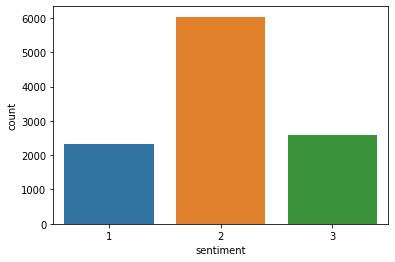

In [46]:
import seaborn as sns
sns.countplot(df['sentiment'])

## Implementação de uma RNN utilizando PyTorch

Escolhi utilizar a biblioteca do PyTorch, baseada na biblioteca torch, para a implementação de uma rede neural. Esta biblioteca é utilizada para aplicações de deep learning e NLP.
>O PyTorch é um software open source gratuito e foi inicialmente desenvolvido pela equipe de pesquisa de AI do Facebook.

### Arquitetura da Rede

Vou, então, implementar uma rede neural recorrente que classifica os sentimentos desses reviews. Na imagem abaixo podemos ter uma melhor ideia de como ela é composta (**Obs.**: No lugar das camadas Sigmoid, vamos utilizar uma camada totalmente conectada com ativação softmax):

<img src="network_diagram.png" width=40%>

**Primeiro, vamos passar as palavras por uma camada de "mergulho" (embedding layer, em inglês)**
>Precisamos dessa camada inicial pois temos milhares de palavras e precisamos ser mais eficientes nas representações de nossos dados de input. No nosso caso, esta camada é utilizada para fins de redução da dimensionalidade. Utilizando essa camada de mergulho, e deixando o algoritmo aprender sozinho uma nova representação, já é possível obter uma boa acurácia.

**Após passarmos o input na camada de mergulho, os novos embeddings são passados pelas células LSTMs**
>A LSTM é responsável por adicionar conexões recorrentes eficientes para o tratamento de textos, nos dando informações sobre a sequência de texto, ao invés de informações das palavras de forma isolada.

**Por fim, a LSTM gera um output que é passado por uma última camada totalmente conectada**
>A última camada vai ser composta por uma camada totalmente conectada (de 3 neurons), pois temos 3 tipos de inputs diferentes (negativo, neutro e positivo). Por fim, a função de ativação escolhida vai ser a função softmax, que é uma boa escolha para tratar a classificação multiclasse.

(Considerando a imagem anterior, não é necessário se preocupar com as saídas da função de ativação, exceto para a **última**; podendo ignorar as restantes. Mais a frente, vamos calcular a loss function comparando o output do último passo com os labels de treinamento.)

----

## Pré-processamento dos dados

O primeiro passo antes de construir a rede neural é transformar os dados na melhor forma para inserir na rede. Como vamos usar camadas de embedding, vai ser necessário codificar cada palavra como um inteiro. Além disso, também é necessário "limpar" os ruídos.

Os passos de processamento serão divididos em:
>* Excluir os períodos e pontuações diversas (se houverem);
* E combinar todas as palavras em uma grande string para codificar as palavras em vetores unitários.

In [8]:
# Arrumando as frases. Vamos substituir todas as maiusculas por
# minusculas e tirar quaisquer pontuaçoes desnecessárias dos dados
# (tanto de treinamento quanto de teste):

import re # Esta é a biblioteca ReGex, usada para auxiliar a localização
          # de padrões


accent_map = {u'\u00c0': u'A', u'\u00c1': u'A', u'\u00c2': u'A', u'\u00c3': u'A', u'\u00c4': u'A', u'\u00c5': u'A', u'\u00c6': u'A', u'\u00c7': u'C', u'\u00c8': u'E', u'\u00c9': u'E', u'\u00ca': u'E', u'\u00cb': u'E', u'\u00cc': u'I', u'\u00cd': u'I', u'\u00ce': u'I', u'\u00cf': u'I', u'\u00d0': u'D', u'\u00d1': u'N', u'\u00d2': u'O', u'\u00d3': u'O', u'\u00d4': u'O', u'\u00d5': u'O', u'\u00d6': u'O', u'\u00d7': u'x', u'\u00d8': u'0', u'\u00d9': u'U', u'\u00da': u'U', u'\u00db': u'U', u'\u00dc': u'U', U'\u00dd': u'Y', u'\u00df': u'B', u'\u00e0': u'a', u'\u00e1': u'a', u'\u00e2': u'a', u'\u00e3': u'a', u'\u00e4': u'a', u'\u00e5': u'a', u'\u00e6': u'a', u'\u00e7': u'c', u'\u00e8': u'e', u'\u00e9': u'e', u'\u00ea': u'e', u'\u00eb': u'e', u'\u00ec': u'i', u'\u00ed': u'i', u'\u00ee': u'i', u'\u00ef': u'i', u'\u00f1': u'n', u'\u00f2': u'o', u'\u00f3': u'o', u'\u00f4': u'o', u'\u00f5': u'o', u'\u00f6': u'o', u'\u00f8': u'0', u'\u00f9': u'u', u'\u00fa': u'u', u'\u00fb': u'u', u'\u00fc': u'u'}


def accent_remove(m):
    return accent_map[m.group(0)]

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
    
def clean_tts(list_to_clean):
    for idx, item in enumerate(list_to_clean):
        # transforma tudo para str
        list_to_clean[idx] = str(item)
        # retira todo o link https:// do tuite
        list_str = list_to_clean[idx].split()
        string = ' '.join([word for word in list_str if not re.search('https://t.co', word)])
        #remove acentos
        list_to_clean[idx] = re.sub(u'([\u00C0-\u00FC])', accent_remove, string.encode().decode('utf-8'))
        # remove emojis
        string = list_to_clean[idx].encode('ascii', 'ignore').decode('ascii')
        list_to_clean[idx] = remove_emoji(string)
        # deixa tudo em caixa baixa
        list_to_clean[idx] = list_to_clean[idx].lower()
        # substitui o restante dos caracteres desnecessarios
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('[…•\-\(\)\&]', '', string)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('\W\s-', '', string)
        string = list_to_clean[idx]
        list_to_clean[idx] = re.sub('["º°/_]', ' ', string)
        # separa pontuações no final das palavras
        char = '...'
        string = list_to_clean[idx]
        res = [i for j in string.split(char) for i in (j, char)][:-1] 
        list_to_clean[idx] = ' '.join(res)
        char = '?'
        string = list_to_clean[idx]
        res = [i for j in string.split(char) for i in (j, char)][:-1] 
        list_to_clean[idx] = ' '.join(res) 
        char = '!'
        string = list_to_clean[idx]
        res = [i for j in string.split(char) for i in (j, char)][:-1] 
        list_to_clean[idx] = ' '.join(res)
        char = '.'
        string = list_to_clean[idx]
        res = [i for j in string.split(char) for i in (j, char)][:-1] 
        list_to_clean[idx] = ' '.join(res)
        char = ','
        string = list_to_clean[idx]
        res = [i for j in string.split(char) for i in (j, char)][:-1] 
        list_to_clean[idx] = ' '.join(res)
        # remove palavras de comprimento menor que 3
        string_list = list_to_clean[idx].split() 
        strings = [x for x in string_list if len(x)>2]
        list_to_clean[idx] = ' '.join(strings)
        # remove espaços desnecessarios
        string_list = list_to_clean[idx].split()
        list_to_clean[idx] = ' '.join(string_list)
    return list_to_clean

In [9]:
texts_list = texts.to_list()

clean_texts = clean_tts(texts_list)
print(clean_texts[:20])

['aproveite quarentena assista clip @blasthrash #fakenews #quarentena #coronavirus #coronavirusbrasil', '#jaba #resenha #blogues quer uma #indicacao bom #livro para estes tempos #quarentena', 'presidente @jairbolsonaro senhor pode convocar minha sogra para @minsaude 4dia #quarentena ela', 'vendo uma serie para esquecer pouco todo esse problema quanto estou #quarentena preventiva', '#fiqueemcasa uma campanha cartacapital via @youtube', 'dia #quarentena', '#witzel sensato atropele competencia p**** toda mesmo para impor #quarentena', 'porque nao pode quero fica rua #quarentena', 'partiu tocar ver friends nessa quarentena #quarentena', 'enquanto isso efeitos #quarentena chegou aqui nos vizinhos meu escritorio eles estao discutindo', 'todas atualizacoes que voce ouvir sobre numero pessoas infectadas por #coronavirus sarscov2 estao pelo men', 'dia quarentena descobri que moram outras pessoas aqui casa simpaticas ate #quarentena #coronavirus', 'queria umas cervejas agora #quarentena', 'desta

In [10]:
sentiments = sentiments.to_list()

print(sentiments[:10])

[2, 2, 1, 1, 3, 2, 3, 1, 2, 1]


In [11]:
all_text = []
for idx, item in enumerate(clean_texts):
    string = item

    for idx, item in enumerate(string.split(' ')):
        all_text.append(item)

print(all_text[:100])

['aproveite', 'quarentena', 'assista', 'clip', '@blasthrash', '#fakenews', '#quarentena', '#coronavirus', '#coronavirusbrasil', '#jaba', '#resenha', '#blogues', 'quer', 'uma', '#indicacao', 'bom', '#livro', 'para', 'estes', 'tempos', '#quarentena', 'presidente', '@jairbolsonaro', 'senhor', 'pode', 'convocar', 'minha', 'sogra', 'para', '@minsaude', '4dia', '#quarentena', 'ela', 'vendo', 'uma', 'serie', 'para', 'esquecer', 'pouco', 'todo', 'esse', 'problema', 'quanto', 'estou', '#quarentena', 'preventiva', '#fiqueemcasa', 'uma', 'campanha', 'cartacapital', 'via', '@youtube', 'dia', '#quarentena', '#witzel', 'sensato', 'atropele', 'competencia', 'p****', 'toda', 'mesmo', 'para', 'impor', '#quarentena', 'porque', 'nao', 'pode', 'quero', 'fica', 'rua', '#quarentena', 'partiu', 'tocar', 'ver', 'friends', 'nessa', 'quarentena', '#quarentena', 'enquanto', 'isso', 'efeitos', '#quarentena', 'chegou', 'aqui', 'nos', 'vizinhos', 'meu', 'escritorio', 'eles', 'estao', 'discutindo', 'todas', 'atualiz

### Codificando as palavras

Para utilizarmos a camada de mergulho ("embedding layer"), precisamos passar números inteiros na rede. Uma forma de fazer isso é criando um dicionário que mapeia palavras para números, tornando possível a conversão de cada uma das palavras dos reviews em números.

Mais tarde, vamos acrescentar zeros (o chamado "padding") nos vetores de input.

In [12]:
# Vamos então contar as palavras (para futuras análises - opcional)
from collections import Counter

counts = Counter(all_text)

In [13]:
# E criar um vocabulário, ordenado a partir das palavras mais faladas
# Obs.: Este vocabulário é composto de palavras únicas, pois
# o método Counter() conta as aparições de cada palavra e
# retorna um vocabulário com o número de aparições e as strings
vocabulary = sorted(counts, key=counts.get, reverse=True)
print("Total de palavras em todos os tweets: {}".format(len(all_text)))
print("Total de palavras no vocabulario: {}".format(len(vocabulary)))

Total de palavras em todos os tweets: 121649
Total de palavras no vocabulario: 19933


In [14]:
# Criando um novo dicionário, que mapeia cada palavra (a partir da que
# mais aparece) em números, começando de 1:
vocabulary_to_int = {}
int_to_vocabulary = {}
for i, word in enumerate(vocabulary, 1):
    vocabulary_to_int[word] = i
    int_to_vocabulary[i] = word

# Forma alternativa, utilizando dict comprehension
# vocabulary_to_int = {word: i for i, word in enumerate(vocabulary, 1)}

In [15]:
# E agora transformando cada review em números
# e 'abusando' das list comprehensions:
texts_int = []
for review in clean_texts:
    texts_int.append([vocabulary_to_int[word] for word in review.split()])

In [16]:
# Conferindo:
print("Palavras únicas: ", len(vocabulary_to_int))
print()
print("Review em formato token:\n", texts_int[3])

Palavras únicas:  19933

Review em formato token:
 [208, 12, 246, 4, 2461, 211, 63, 38, 455, 324, 55, 1, 2910]


In [17]:
# E para uso futuro, vamos já deixar o vetor dos labels
# de sentimentos pronto. O label da posição x ('encoded_label[x]')
# corresponde ao review 'texts_set_int[x]':
import numpy as np

# Aqui vamos aproveitar para deixar as labels indexadas em 0, para evitar problemas futuros durante o treino da rede
encoded_labels = np.array([(int(sentiments[i])-1) for i in range(1,len(sentiments))])
                          
print(encoded_labels[0])

# E os dados de teste codificados:
texts_set_int = []
for review in texts_int:
    texts_set_int.append(review)

print()
print(texts_set_int[0])

1

[572, 8, 799, 7481, 7482, 2909, 1, 11, 47]


In [18]:
# Para conferir se as conversões estão de acordo com o esperado...

review_49 = texts_set_int[49] # review em formato token
print(review_49)
review_49_words = ' '.join([int_to_vocabulary[i] for i in review_49]) # refazendo a conversão
print(review_49_words)
print()
print(sentiments[49])
# Obs.: a partir daqui, os dados estão "shifted" por uma casa a menos,
# isso pq nos dados anteriores tínhamos os cabeçalhos (aquele com os títulos
# das colunas em formato string).

[300, 459, 513, 7537, 410, 168, 7538, 7539, 1]
apenas consciencia #prevencao #ajuda #coronavirusbrazil #corona #pescaria #pesca #quarentena

3


### Removendo outliers

Um passo de pre-processamento adicional é o de padronizar nossos inputs. Isto é, nossa rede vai esperar como input um vetor de tamanho fixo. Assim, queremos formatar nossos reviews em um tamanho específico.

Para fazer isso, podemos dividir o processo em dois passos:

1. Retirar os reviews outliers (i.e., aqueles muito compridos ou muito curtos);
2. Preencher (o famoso *padding*) ou truncar o restante dos dados, de forma a termos reviews com o mesmo tamanho.

In [19]:
# Vamos procurar por reviews "extremos", aqueles
# que podem "bagunçar" com o treinamento:

tamanho_reviews = Counter([len(x) for x in texts_set_int]) # Dict: {objeto: contagem}
print("Número total de reviews: {}".format(len(texts_set_int)))
print("Quantos reviews de tamanho nulo: {}".format(tamanho_reviews[0]))
print("Tamanho máximo de um review: {}".format(max(tamanho_reviews)))

Número total de reviews: 10953
Quantos reviews de tamanho nulo: 2
Tamanho máximo de um review: 22


In [20]:
print(tamanho_reviews)

Counter({13: 1234, 14: 1200, 12: 1021, 15: 993, 11: 945, 10: 815, 9: 694, 16: 663, 8: 629, 7: 609, 5: 497, 6: 491, 17: 332, 4: 313, 3: 234, 18: 134, 2: 71, 19: 51, 20: 14, 1: 5, 21: 5, 0: 2, 22: 1})


In [21]:
tamanho = sorted([key for key in tamanho_reviews.keys()])
numero = [tamanho_reviews[lenght] for lenght in tamanho]

In [22]:
import matplotlib.pyplot as plt
plt.plot(tamanho, numero)
plt.xlabel('Tamanho do tweet de treinamento')
plt.ylabel('No. de tweets')
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
# Vamos então retirar os reviews de tamanho nulo e os
# seus respectivos labels dos reviews:

# Pegando os indices dos reviews de tamanho não nulo:
non_zero_idx_train = [i for i, review in enumerate(texts_set_int) if len(review) != 0]

In [24]:
# Removendo os reviews nulos e seus labels:
train_set_int = [texts_set_int[i] for i in non_zero_idx_train]
encoded_labels = np.array([encoded_labels[i] for i,j in enumerate(non_zero_idx_train)])

print("Número de reviews antes da remoção dos reviews nulos: ", len(texts_set_int))
print("Número de reviews após a remoção dos reviews nulos: ", len(train_set_int))

Número de reviews antes da remoção dos reviews nulos:  10953
Número de reviews após a remoção dos reviews nulos:  10951


In [25]:
print(len(encoded_labels))
print(len(train_set_int))

10951
10951


### Realizando o preenchimento (*padding*)

Para lidarmos com ambas as reviews (curtas e longas), a gente pode truncar ou preencher todos os nossos reviews, constringindo os reviews a um comprimento específico.

Para reviews menores que um determinado comprimento `seq_length`, a gente preenche o vetor com 0's. Para reviews maiores que esse mesmo comprimento, a gente trunca ele nas primeiras palavras.

Vamos considerar inicialmente um tamanho para a `seq_length` de 22, que foi o tamanho máximo encontrado.

In [26]:
def padding_features(review_ints, seq_length):
    ''' Retorna vetores (features) dos review_ints contidos
        ou preenchidos até o limite de tamanho seq_length
    '''
    
    # Aqui produzimos um vetor com a forma desejada de linhas x colunas:
    features = np.zeros((len(review_ints),seq_length), dtype=int)
    
    # Para cada review:
    for i, row in enumerate(review_ints):
        features[i, -len(row):] = np.array(row[:seq_length])
    
    return features

In [27]:
seq_length = 22
features_train = padding_features(train_set_int, seq_length=seq_length)

# Para testar o código, podemos usar assert:
# assert len(features) == len(train_set_int), "As features devem ter o número de linhas igual ao numero de reviews"
# assert len(features[0]) == seq_length, "Cada linha deve ter o mesmo comprimento"

print(features_train[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0  572
     8  799 7481 7482 2909    1   11   47]
 [   0    0    0    0    0    0    0    0    0    0 7483 7484 7485  216
    12 7486   66 7487    4 1305   89    1]
 [   0    0    0    0    0    0    0    0    0    0  146  293  532   62
  7488   23 3631    4 1117 7489    1  144]]


### Dividindo o conjunto de treinamento em Treinamento, Validação e Teste

> Vamos agora dividir o conjunto de treinamento em três  grupos: um de validação, o outro para treinamento e um final para teste (Escolhi fazer isso para ser mais uma estapa de mensuração do código antes de submetê-lo ao benchmarking -- que é o conjunto de testes lá de cima que viemos trabalhando até aqui). Para isso:
* Vamos criar um conjunto das features para treino (`train_x`) e um conjunto de suas labels (`train_y`);
* Definir uma fração de *split* (`split_frac`) para ser a fração dos dados a serem **mantidos** no conjunto de treinamento. (Geralmente é de 0.8 ou 0.9);
* O Restante é dividido no meio, em conjunto de validação (`val_x` e `val_y`) e conjunto de teste (`test_x` e `test_y`).

### Criando DataLoaders e Batching

Agora estamos chegando na parte "legal" rsrs

Agora que temos os nossos dados *bonitinhos* em mãos, precisamos de um método para criar nossos conjuntos de inputs de forma a minimizar o *overfitting* por conta de uma ordem específica presente nos dados.

Uma forma é utilizando o [TensorDataset](https://pytorch.org/docs/stable/data.html#) para acessar os dados e criar os datasets. Utilizando a função *DataLoader* podemos criar pequenos *batchs*, escolhidos aleatoriamente dentre os dados.

## Rede de Sentimentos usando PyTorch

Relembrando, vamos dividir a nossa rede em três principais componentes (camadas):
1. Uma [camada de *embedding*](https://pytorch.org/docs/stable/nn.html#embedding) que converte os nossos tokens de palavras (inteiros) em vetores de um tamanho específico;
2. Uma camada de [LSTM](https://pytorch.org/docs/stable/nn.html#lstm), que é definida pelo tamanho do `hidden_state` e pelo número de camadas;
3. Uma camada de output totalmente conectada que mapeia os outputs da camada LSTM aos outputs do tamanho desejado (`output_size`);
4. E por fim uma função ativadação *softmax* que transforma os outputs em probabilidades de classe.

### A camada de *embedding*

Precisamos de uma camada de embedding pois temos mais de 19000 palavras no nosso vocabuário (este inclusive pode ser um problema no geral, pois essa quantidade é relativamente baixa em comparação às +170000 palavras não-obsoletas existentes em inglês).

### As camadas da LSTM

A LSTM vai receber um tamanho de input `input_size`, a dimensão da camada oculta `hidden_dim`, o número de camadas, uma probabilidade de dropout (no caso de múltiplas camadas) e um parâmetro de `batch_first`.

Na maioria das vezes, a rede pode ter entre 2 e 3 camadas. Adicionar essas camadas permite um aprendizado de relações mais complexas pela rede.

### Instanciando a rede

Vamos instanciar a rede definindo os parâmetros:
* `vocab_size`: O tamanho do nosso vocabulário, ou o range dos valores do nosso input (tokens);
* `output_size`: O tamanho do nosso output desejado; É o número de scores da nossa classe (1-3);
* `embedding_dim`: Número de colunas na tabela do embedding; É o tamanho dos nossos embeddings;
* `hidden_dim`: Número de unidades na camada oculta das nossas células de LSTM. Geralmente quanto maior, melhor a performance. Os tamanhos mais comuns são 128, 256, 512, etc.;
* `n_layers`: É o número de camadas LSTM na rede. Geralmente ficam entre 1-3.

### Treinamento

Vamos estar usando a [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss), a chamada *Cross Entropy Loss*. Ela foi desenhada para trabalhar com problemas de classificação com C classes. 

Nesta fase também precisamos de outros *hyperparameters*:
* `lr`: a learning rate do nosso otimizador escolhido;
* `epochs`: o número de vezes que vamos iterar pelo dataset de treinamento;
* `clip`: que é o valor máximo do gradiente para evitar o problema do "explosive gradients".

## Testando a rede

Existem algumas formas de testar uma rede neural. Podemos testá-la através de:

* **Teste de performance dos dados**: Primeiro vemos como nosso modelo performa em todos os `test_data` lá de cima, calculando o loss médio e a acurácia sobre os dados de teste;
* **Inferência em dados gerados pelo usuário**: Podemos inserir um review por vez (sem o label) e ver o que o modelo treinado retorna.

Aqui vou me ater apenas ao primeiro caso:

Realizei no total 2 treinos completos.

Os dados sobre os treinos eu deixei no arquivo texto 'treino-sentiment-rnn.txt' para consultas.

Apenas nos dois últimos treinos que realizei a verificação, sendo a melhor acurácia total obtida a de 59% (treino anterior a esse último). 

### Usando o keras ao invés do PyTorch

In [47]:
seed = 42

import random
import numpy as np
from tensorflow import set_random_seed

random.seed(seed)
np.random.seed(seed)
set_random_seed(seed)

from keras.preprocessing import sequence,text
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, confusion_matrix, recall_score, precision_score

Using TensorFlow backend.


In [48]:
import re
def del_num(string):
    string = str(string)
    string = string.lower()
    string = re.sub('\W+\s', '', string)
    string = re.sub('\d+', '', string)
    string = re.sub('[\(\)/:*.-]', ' ', string)
    string = string.split()
    new_string = [i for i in string if len(i) > 2]
    string = ' '.join(new_string)
    return string

In [49]:
### SELECIONANDO OS DADOS DE TREINAMENTO E AS LABELS ###
x = df['original_text'].apply(del_num)
y = df['sentiment'].apply(lambda x: x-1)

In [50]:
# Aqui eu já indexei os sentimentos em 0 (0 - negativo, 1- neutro, 2- positivo)
print("Tweet: ", x[1],"\nSentiment: ", y[1])

Tweet:  #jabá #resenha #blogues quer uma #indicação bom #livro para estes tempos #quarentenahttps afqqzpdn 
Sentiment:  1


In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0, shuffle=True)

1    6037
2    2587
0    2329
Name: sentiment, dtype: int64

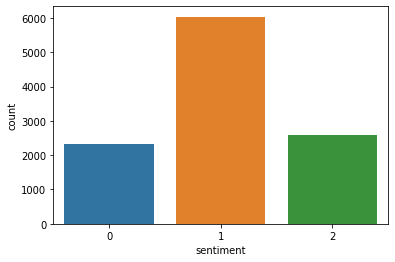

In [52]:
### VERIFICANDO O BALANCEAMENTO DE CADA CLASSE DE INTERESSE ###
sns.countplot(y)
y.value_counts()

In [53]:
from sklearn.utils import resample

X = pd.concat([x_train, y_train], axis=1)
X.head()

,original_text,sentiment
1216,#danielnews #profdanielramos #pbh #alexandreka...,1
729,minha pinscher fez mais pelo brasil que bolson...,2
9397,não existe ser mais resistente que cariocasobr...,1
8452,aproveitando quarentena para assistir todos fi...,2
379,povo que sabe cantar tudo fazendo vídeoqueria ...,1


In [63]:
category0 = X[X.sentiment==0]
category1 = X[X.sentiment==1]
category2 = X[X.sentiment==2]

In [64]:
number=len(category1)
category0_upsampled = resample(category0,
                          replace=True,
                          n_samples=number,
                          random_state=1)
category1_upsampled = resample(category1,
                          replace=True,
                          n_samples=number,
                          random_state=1)
category2_upsampled = resample(category2,
                          replace=True,
                          n_samples=number,
                          random_state=1)

In [65]:
resampled_data = pd.concat([category0_upsampled, category1_upsampled, category2_upsampled])

In [66]:
resampled_data.sentiment.value_counts()

2    14436
1    14436
0    14436
Name: sentiment, dtype: int64

In [67]:
x_train = resampled_data['original_text']
y_train = resampled_data['sentiment']

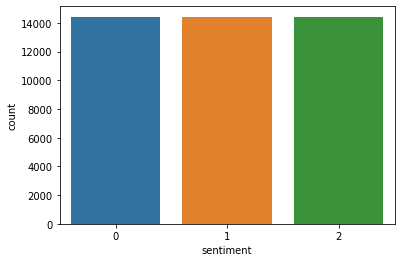

In [68]:
sns.countplot(y_train)

In [70]:
tam_vocab = len(vocabulary)
tokenizer = Tokenizer(num_words=tam_vocab)
tokenizer.fit_on_texts(list(x_train))
tokenizer.fit_on_texts(list(x_test))

In [71]:
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
X_train = pad_sequences(X_train, maxlen=22)
X_test = pad_sequences(X_test, maxlen=22)
print(len(X_train))
X_train[:5]

43308


array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     4,   226,    29,   446,   141,    53,    35,
           13,    11,    57,  7072],
       [    0,     0,     0,     0,   145,   286,  3341,  3959,     2,
          176,   639,   196,   847,  3960,   640,     2,   136,   194,
           15,   629,   174,  3961],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   104,   125,     5,   141,
            2,   769,     1,     3],
       [    0,     0,     0,     0,    16,  1209,    21,  1343,   162,
         2016,    10, 12165,    16,   316,   212,   524,    19,   144,
          459,    93,  2017,     1],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   235,   385,    15,   619,   290,
           27,   308,     1,    13]], dtype=int32)

In [72]:
Y_train = to_categorical(y_train.values)
print(len(Y_train))
Y_train.shape

43308


(43308, 3)

In [73]:
print(X_train.shape, Y_train.shape, X_test.shape, y_test.shape)

(43308, 22) (43308, 3) (2191, 22) (2191,)


In [74]:
train_x, val_x, train_y, val_y = train_test_split(X_train, Y_train, test_size=0.2)

In [75]:
max_features = len(vocabulary)

In [92]:
model=Sequential()
model.add(Embedding(max_features,512,mask_zero=True))
model.add(LSTM(256,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(512,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 256)         5102848   
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 7,204,611
Trainable params: 7,204,611
Non-trainable params: 0
_________________________________________________________________


In [94]:
epochs = 50
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 34646 samples, validate on 8662 samples
Epoch 1/50
34646/34646 [==============================] - 229s 7ms/step - loss: 0.5314 - accuracy: 0.7658 - val_loss: 0.1574 - val_accuracy: 0.9501
Epoch 2/50
34646/34646 [==============================] - 217s 6ms/step - loss: 0.0870 - accuracy: 0.9717 - val_loss: 0.0759 - val_accuracy: 0.9770
Epoch 3/50
34646/34646 [==============================] - 218s 6ms/step - loss: 0.0419 - accuracy: 0.9866 - val_loss: 0.0655 - val_accuracy: 0.9834
Epoch 4/50
34646/34646 [==============================] - 221s 6ms/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.0662 - val_accuracy: 0.9850
Epoch 5/50
34646/34646 [==============================] - 214s 6ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0664 - val_accuracy: 0.9850
Epoch 6/50
34646/34646 [==============================] - 212s 6ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.0695 - val_accuracy: 0.9863
Epoch 7/50
34646/34646 [==============================] - 211s 

In [95]:
predictions = model.predict_classes(X_test, batch_size=batch_size, verbose=1)

2191/2191 [==============================] - 4s 2ms/step


In [96]:
pd.DataFrame(confusion_matrix(y_test, predictions))

,0,1,2
0,136,275,68
1,122,939,164
2,40,321,126


In [97]:
accuracy_score(y_test, predictions)

0.5481515289821999

In [98]:
f1_score(y_test, predictions, average=None)

array([0.35006435, 0.68043478, 0.29822485])

### Rápida conclusão

Nesse desafio, vimos como realizar a implementação de uma rede neural recorrente capaz de prever sentimentos de reviews.

Para uma boa implementação de um modelo como este, são necessárias três etapas importantes: A de organização e limpeza de dados, a escolha da arquitetura, e a fase de treinamento e validação. 

Por fim, é possivel aprimorarmos a rede se utilizarmos mais camadas internas da LSTM, ou também se utilizarmos um maior número de dados de treinamento. Para isto seria necessário desprender maior tempo para a tabulação de outros tweets. É possível também treinarmos uma camada de embedding separadamente da rede recorrente, utilizando um vocabulário mais completo.
